# 2.156 Final Project
**Becca Sholler, Grayson Adams, Ryan DeQuintal**

## Load Data

In [1]:
import os
import shutil
import random
from pathlib import Path
import requests
from urllib.parse import urlencode, urlparse, parse_qsl, urlunparse
from tqdm import tqdm

data_dir = "https://www.dropbox.com/scl/fo/3d3kttc96e8a5izrhr9du/ABGbVWFKYaUZNu9jtNVnwDY?rlkey=lvo18dm41lb4jbyarzznvwtvx&st=gv5sxb2t&dl=0"
source_root = Path("data/source_dataset")
target_root = Path("data/split_dataset")
splits = ["train", "val", "test"]
ratios = {"train": 0.7, "val": 0.15, "test": 0.15}

def _to_direct_dropbox(url):
    parsed = urlparse(url)
    query = dict(parse_qsl(parsed.query))
    query["dl"] = "1"
    return urlunparse(parsed._replace(query=urlencode(query)))

needToDownload = True
if needToDownload:
    download_url = _to_direct_dropbox(data_dir)
    zip_path = source_root.parent / "source_dataset.zip"
    source_root.mkdir(parents=True, exist_ok=True)

    print(f"Downloading dataset from Dropbox...")
    with requests.get(download_url, stream=True) as resp:
        resp.raise_for_status()
        total_size = int(resp.headers.get('content-length', 0))
        
        with open(zip_path, "wb") as fh:
            with tqdm(total=total_size, unit='B', unit_scale=True, desc="Downloading") as pbar:
                for chunk in resp.iter_content(chunk_size=8192):
                    if chunk:
                        fh.write(chunk)
                        pbar.update(len(chunk))

    print("Extracting archive...")
    shutil.unpack_archive(str(zip_path), str(source_root))
    zip_path.unlink()
    print('✓ Files downloaded and extracted.')

    print("Creating train/val/test splits...")
    # Create target folders
    for split in splits:
        for class_name in os.listdir(source_root):
            class_path = os.path.join(source_root, class_name)
            if os.path.isdir(class_path):
                os.makedirs(os.path.join(target_root, split, class_name), exist_ok=True)

    # Split the data per class
    random.seed(2156)
    for class_name in tqdm(os.listdir(source_root), desc="Splitting classes"):
        class_dir = os.path.join(source_root, class_name)
        if not os.path.isdir(class_dir):
            continue
            
        images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
        random.shuffle(images)

        n = len(images)
        n_train = int(n * ratios["train"])
        n_val   = int(n * ratios["val"])

        train_files = images[:n_train]
        val_files   = images[n_train:n_train+n_val]
        test_files  = images[n_train+n_val:]

        for f in train_files:
            shutil.copy(os.path.join(class_dir, f), 
                        os.path.join(target_root, "train", class_name, f))
        for f in val_files:
            shutil.copy(os.path.join(class_dir, f), 
                        os.path.join(target_root, "val", class_name, f))
        for f in test_files:
            shutil.copy(os.path.join(class_dir, f), 
                        os.path.join(target_root, "test", class_name, f))

    print("✓ Dataset split completed.")

    print("\n" + "="*50)
    print("DATASET READY")
    print(f"Source: {source_root}")
    print(f"Split dataset: {target_root}")
    print("="*50)
else:
    print("Dataset already downloaded and split.")

Downloading: 100%|██████████| 397M/397M [00:47<00:00, 8.42MB/s]   


Extracting archive...
✓ Files downloaded and extracted.
Creating train/val/test splits...


Splitting classes: 100%|██████████| 93/93 [00:00<00:00, 175.29it/s]

✓ Dataset split completed.

DATASET READY
Source: data/source_dataset
Split dataset: data/split_dataset


## Train Model

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tqdm import tqdm, trange
import seaborn as sns
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Load Images 

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
size = (256, 256)

normalize = transforms.Normalize(
    mean=imagenet_mean,
    std=imagenet_std,
)

train_transform = transforms.Compose([
    transforms.Resize(size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
    transforms.Normalize(mean=imagenet_mean,
                         std=imagenet_std)
])

eval_transform = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean,
                         std=imagenet_std)
])

train_data = datasets.ImageFolder(target_root / "train", transform=train_transform)
val_data = datasets.ImageFolder(target_root / "val", transform=eval_transform)
test_data = datasets.ImageFolder(target_root / "test", transform=eval_transform)
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_data,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False)

print(train_data.classes)
print(len(train_data))
images, labels = next(iter(train_loader))
print(images.shape)

['Victaulic_AWWA_Cap_No 60-C (DRG)_10 (250)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_12 (300)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_14 (350)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_16 (400)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_18 (450)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_20 (500)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_24 (600)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_30 (750)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_36 (900)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_4 (100)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_6 (150)', 'Victaulic_AWWA_Cap_No 60-C (DRG)_8 (200)', 'Victaulic_FP_Cplg Rgd_IR_Style 009N (OGS)_1.5 (40)', 'Victaulic_FP_Cplg Rgd_IR_Style 009N (OGS)_10 (250)', 'Victaulic_FP_Cplg Rgd_IR_Style 009N (OGS)_12 (300)', 'Victaulic_FP_Cplg Rgd_IR_Style 009N (OGS)_2 (50)', 'Victaulic_FP_Cplg Rgd_IR_Style 009N (OGS)_3 (80)', 'Victaulic_FP_Cplg Rgd_IR_Style 009N (OGS)_4 (100)', 'Victaulic_FP_Cplg Rgd_IR_Style 009N (OGS)_6 (150)', 'Victaulic_FP_Cplg Rgd_IR_Style 009N (OGS)_8 (200)', 'Victaulic_FP_Cplg Rgd_IR_Style 009V 

In [4]:
class SpatialMask(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, 1, kernel_size=1)
    
    def forward(self, x):
        mask = torch.sigmoid(self.conv(x))   # output in [0,1]
        return x * mask

class ResNetWithMask(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        # Load base ResNet
        self.backbone = models.resnet18(weights='DEFAULT')
        
        # Insert masking after layer4 outputs 512 channels
        self.mask = SpatialMask(512)
        
        # Replace classifier head
        self.backbone.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        # Run through all layers except fc
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # Apply learned mask here
        x = self.mask(x)

        # Continue through classifier
        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.backbone.fc(x)

        return x

In [5]:
def train_model_resnet(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-4, device="cuda"):
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    train_losses = []
    val_losses = []
    val_accuracies = []

    print("Starting training...\n")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # ----- VALIDATION -----
        model.eval()
        running_val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)

        scheduler.step()

        # Early stopping checks
        patience = 3
        delta = 1e-4

        if epoch == 0:
            best_val_loss = epoch_val_loss
            patience_counter = 0
        elif epoch_val_loss + delta < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

        # Print epoch summary
        lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_train_loss:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} | "
              f"Val Acc: {val_accuracy:.4f} | "
              f"LR: {lr:.6f}")

    plt.figure()
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()
    return train_losses, val_losses, val_accuracies

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 202MB/s]


Starting training...

Epoch 1/10 | Train Loss: 4.0474 | Val Loss: 3.1230 | Val Acc: 0.1302 | LR: 0.000100
Epoch 2/10 | Train Loss: 2.9590 | Val Loss: 2.3311 | Val Acc: 0.2525 | LR: 0.000100
Epoch 3/10 | Train Loss: 2.3774 | Val Loss: 2.0376 | Val Acc: 0.2978 | LR: 0.000100
Epoch 4/10 | Train Loss: 1.9992 | Val Loss: 1.7805 | Val Acc: 0.3945 | LR: 0.000100
Epoch 5/10 | Train Loss: 1.7422 | Val Loss: 1.6697 | Val Acc: 0.3905 | LR: 0.000010
Epoch 6/10 | Train Loss: 1.4937 | Val Loss: 1.4581 | Val Acc: 0.4990 | LR: 0.000010
Epoch 7/10 | Train Loss: 1.4592 | Val Loss: 1.4154 | Val Acc: 0.5187 | LR: 0.000010
Epoch 8/10 | Train Loss: 1.3930 | Val Loss: 1.4144 | Val Acc: 0.4990 | LR: 0.000010
Epoch 9/10 | Train Loss: 1.3727 | Val Loss: 1.3838 | Val Acc: 0.5345 | LR: 0.000010
Epoch 10/10 | Train Loss: 1.3506 | Val Loss: 1.3476 | Val Acc: 0.5345 | LR: 0.000001


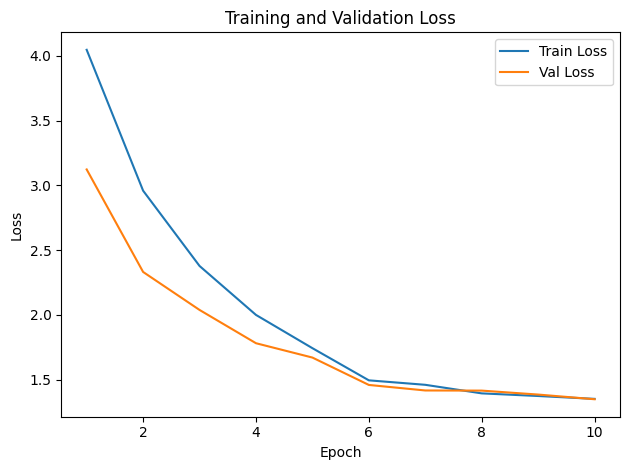

In [6]:
from torchvision import models
import torch.nn as nn

num_classes = len(train_data.classes)

model = ResNetWithMask(num_classes).to(device)  
# model = models.resnet18(weights='DEFAULT')
# model.fc = nn.Linear(model.fc.in_features, num_classes)
# model = model.to(device)

train_losses, val_losses, val_acc = train_model_resnet(
    model, 
    train_loader, 
    val_loader, 
    num_epochs=10,
    learning_rate=1e-4, 
    device=device
)

## Model Evaluation

In [7]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

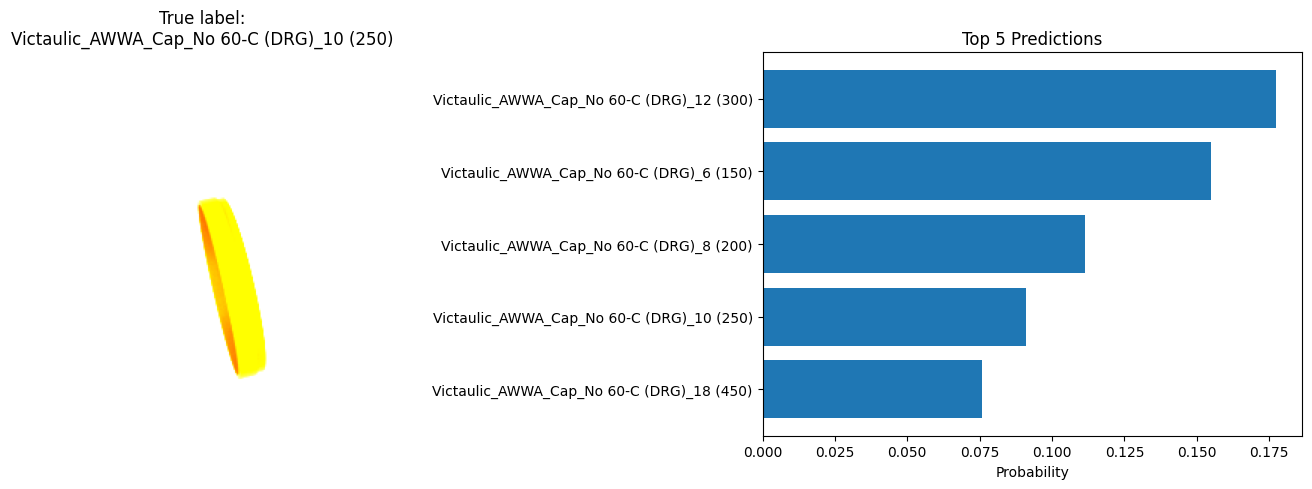

In [8]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def show_topk_prediction(model, dataset, k=5, index=2000):
    model.eval()
    
    # Get image + label
    img, label = dataset[index]
    img_batch = img.unsqueeze(0).to(device)

    # Forward pass
    with torch.no_grad():
        logits = model(img_batch)
        probs = F.softmax(logits, dim=1)[0]
        topk_probs, topk_idx = torch.topk(probs, k=k)

    # Convert to numpy for plotting
    topk_probs = topk_probs.cpu().numpy()
    topk_idx = topk_idx.cpu().numpy()

    class_names = dataset.classes
    topk_labels = [class_names[i] for i in topk_idx]

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Show image
    ax[0].imshow(img.permute(1, 2, 0))  # CHW -> HWC
    ax[0].set_title(f"True label:\n{class_names[label]}")
    ax[0].axis("off")

    # Show bar chart
    ax[1].barh(topk_labels[::-1], topk_probs[::-1])
    ax[1].set_title(f"Top {k} Predictions")
    ax[1].set_xlabel("Probability")

    plt.tight_layout()
    plt.show()

# Example: show 1st test image
show_topk_prediction(model, test_data, k=5, index=0)

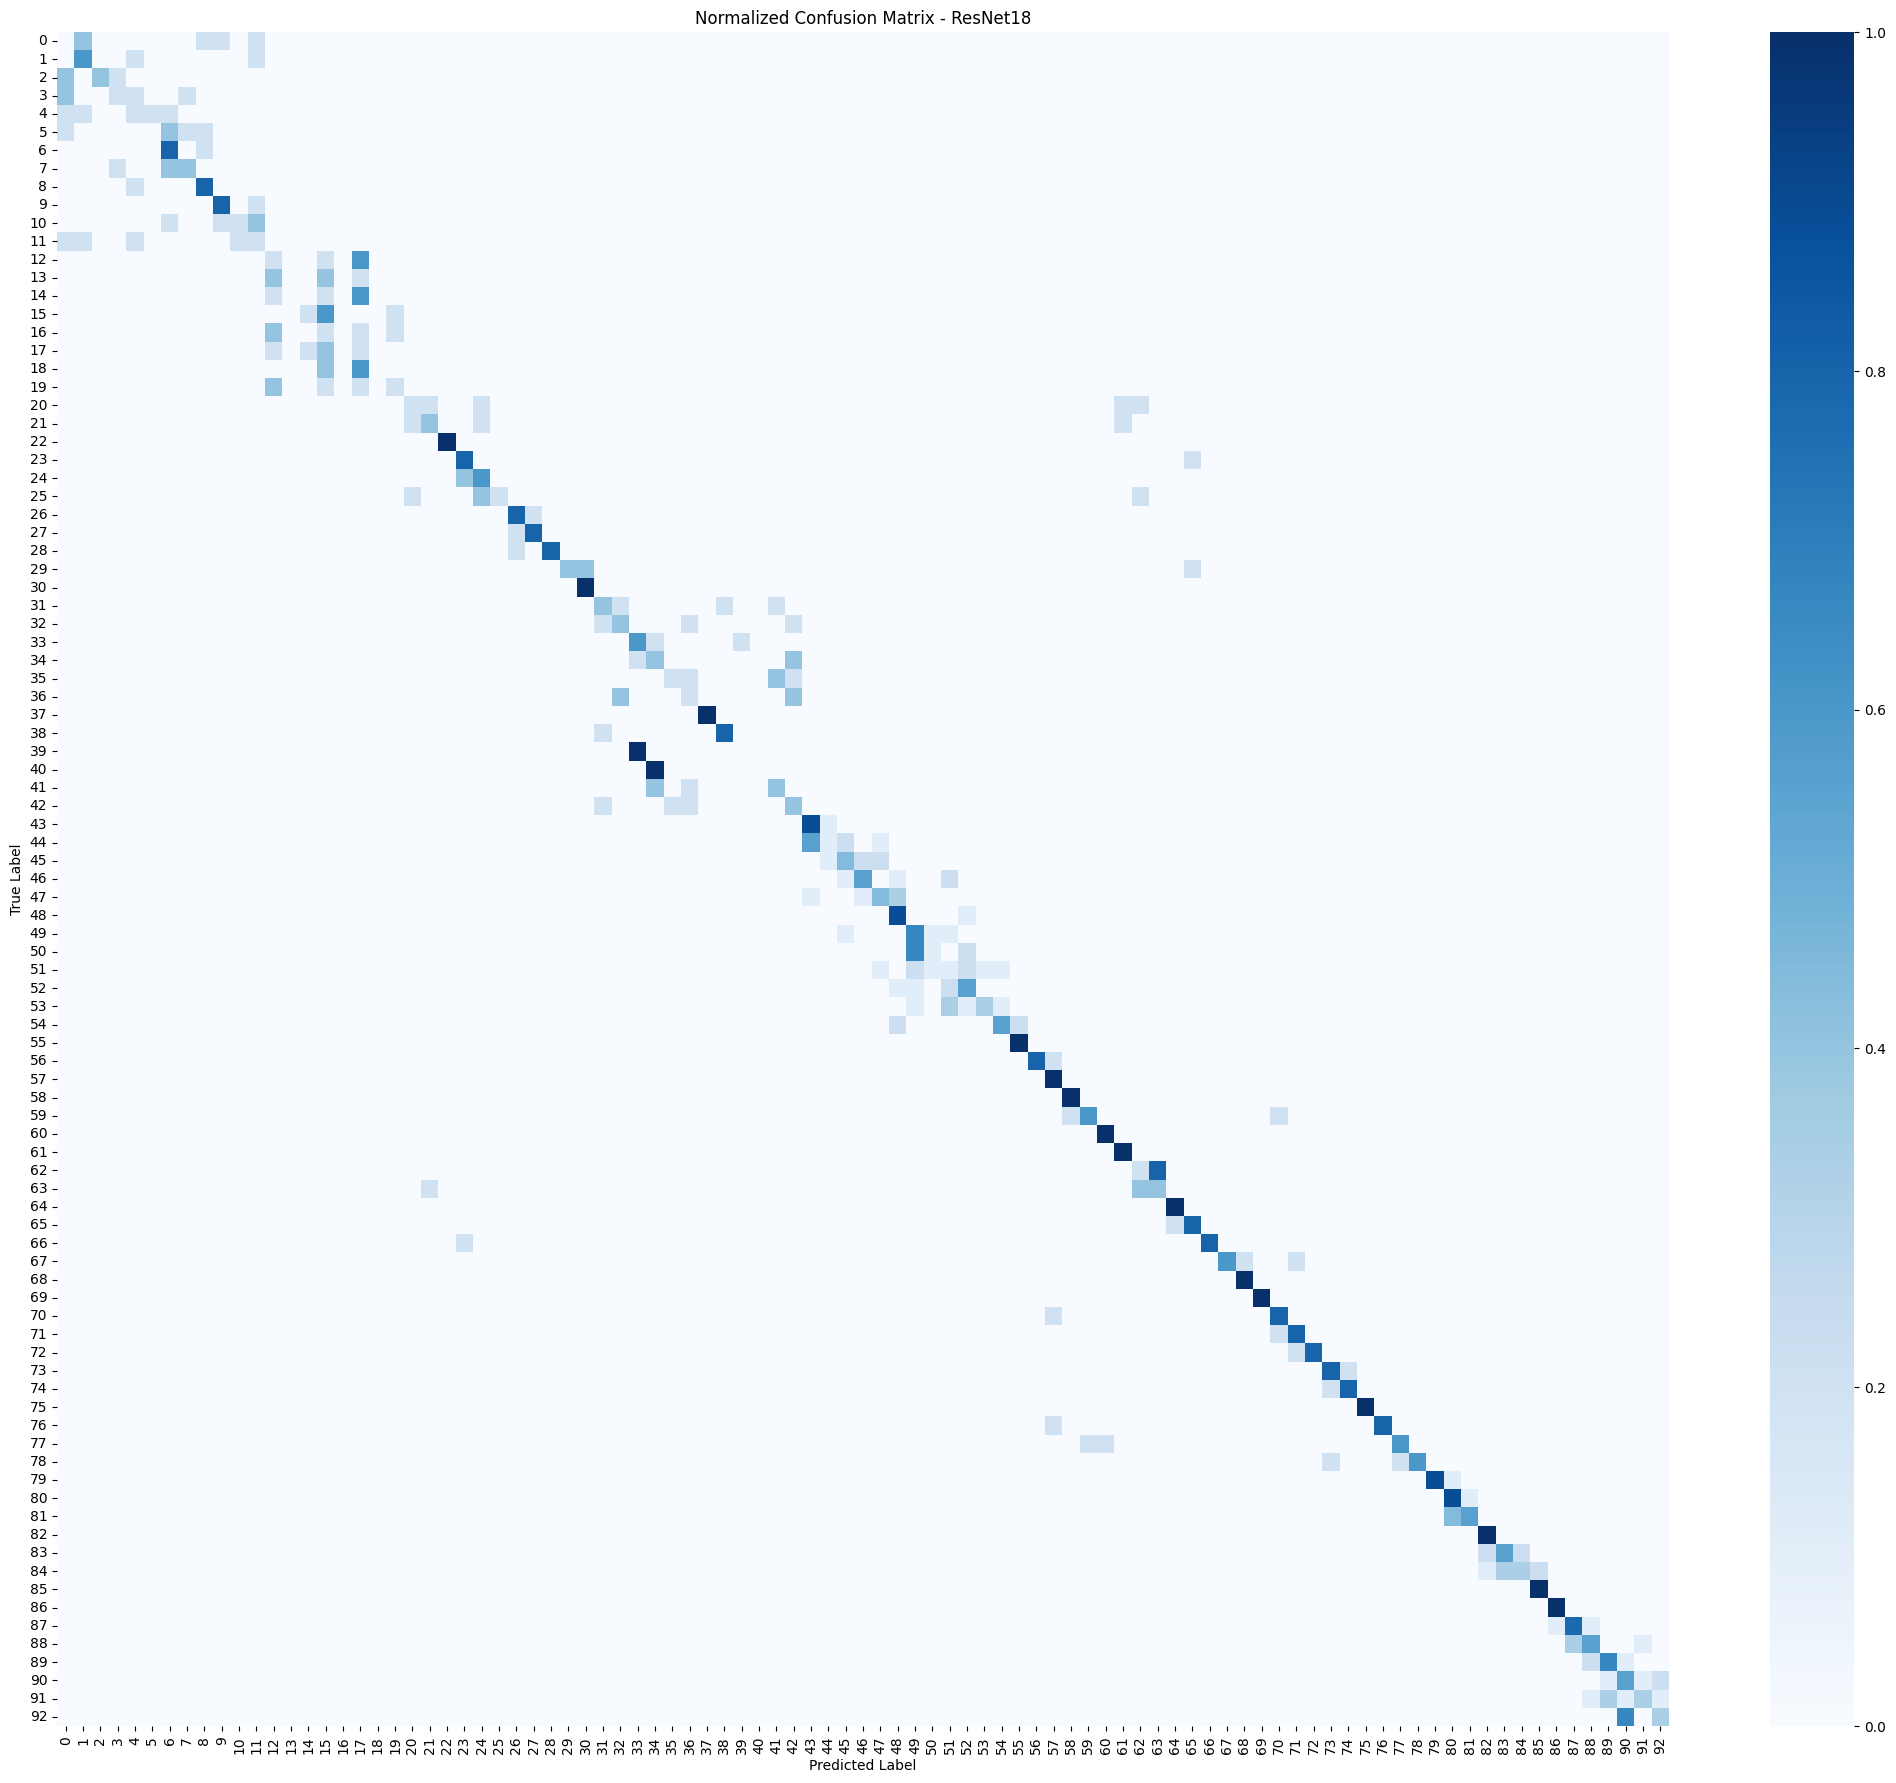

In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(26, 22))
sns.heatmap(cm_norm, 
            cmap="Blues") 
            #xticklabels=class_names,
            #yticklabels=class_names)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Normalized Confusion Matrix - ResNet18")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [10]:
correct = cm.diagonal().sum()
total = cm.sum()
print("Overall Test Accuracy:", correct / total)

Overall Test Accuracy: 0.5654450261780105


## GradCAM Visualization

In [ ]:
!pip install grad-cam

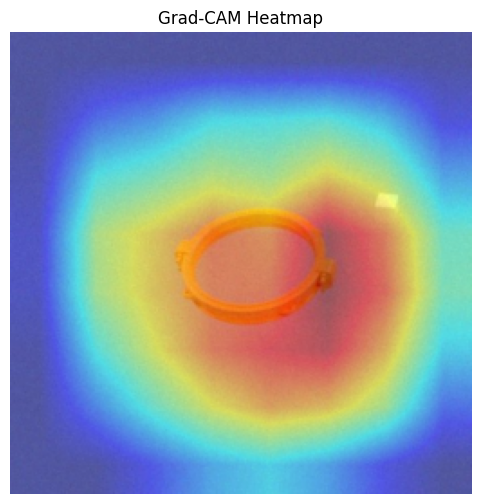

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Pick a ResNet layer — last conv layer
target_layer = model.backbone.layer4[-1].conv2   # works for ResNet18 with your mask

# Initialize CAM (no use_cuda argument in new versions)
cam = GradCAM(model=model, target_layers=[target_layer])

# Pick an image from test set
img, label = test_data[298]
input_tensor = img.unsqueeze(0).to(device)

# CAM target (correct class)
targets = [ClassifierOutputTarget(label)]

# Generate CAM heatmap
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

# Convert image back to [0,1] range
rgb_image = img.permute(1,2,0).cpu().numpy()
rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

# Overlay heatmap
vis = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

plt.figure(figsize=(6,6))
plt.imshow(vis)
plt.axis("off")
plt.title("Grad-CAM Heatmap")
plt.show()

## SHAP Analysis (WIP)

In [ ]:
# import numpy as np
# import random
# import shap
# import torch
# import torch.nn as nn
# import torchvision
# import torchvision.models.resnet
# from torchvision import transforms, datasets
# from captum.attr import GradientShap
# import matplotlib.pyplot as plt


# # ================================
# # FINAL SHAP PIPELINE FOR RESNET
# # ================================


# # ============================================
# # 1. SHAP Dataset (unnormalized images)
# # ============================================

# shap_transform = transforms.Compose([
#     transforms.Resize(size),
#     transforms.ToTensor(),               # IMPORTANT: NO NORMALIZATION HERE
# ])

# # Use your existing dataset paths:
# train_shap = datasets.ImageFolder(target_root / "train", transform=shap_transform)
# test_shap  = datasets.ImageFolder(target_root / "test",  transform=shap_transform)


# # ============================================
# # 2. Patch ResNet to remove all inplace ops
# # ============================================

# import torchvision.models.resnet as resnet

# def patch_resnet_for_shap(model):
#     for name, module in model.named_modules():

#         # Fix all ReLUs
#         if isinstance(module, nn.ReLU):
#             module.inplace = False

#         # Fix BasicBlock residual connections
#         if isinstance(module, resnet.BasicBlock):
#             def new_forward(self, x):
#                 identity = x.clone()

#                 out = self.conv1(x)
#                 out = self.bn1(out)
#                 out = self.relu(out)

#                 out = self.conv2(out)
#                 out = self.bn2(out)

#                 if self.downsample is not None:
#                     identity = self.downsample(identity)

#                 out = out + identity       # SAFE: not inplace
#                 out = self.relu(out)
#                 return out

#             module.forward = new_forward.__get__(module, module.__class__)


# patch_resnet_for_shap(model)   # use your trained model
# model.to(device)
# model.eval()


# # ============================================
# # 3. Wrap model to handle normalization internally
# # ============================================

# class NormalizedModel(nn.Module):
#     def __init__(self, model, mean, std):
#         super().__init__()
#         self.model = model
#         self.mean = torch.tensor(imagenet_mean).view(1, 3, 1, 1).to(device)
#         self.std  = torch.tensor(imagenet_std).view(1, 3, 1, 1).to(device)

#     def forward(self, x):
#         x = (x - self.mean) / self.std
#         return self.model(x)

# model_shap = NormalizedModel(model, mean, std).to(device)
# model_shap.eval()


# # ============================================
# # 4. Create SHAP background
# # ============================================

# background_size = 10
# background = torch.stack([train_shap[i][0] for i in range(background_size)]).to(device)


# # ============================================
# # 5. Build SHAP DeepExplainer
# # ============================================

# e = shap.DeepExplainer(model_shap, background)


# # ============================================
# # 6. Run SHAP on one test image
# # ============================================

# index = 0  # you can change this
# img, label = test_shap[index]
# image_tensor = img.unsqueeze(0).to(device)

# # Compute SHAP values
# shap_values = e.shap_values(image_tensor)

# # Convert image to numpy for plotting
# image_np = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()

# # ============================================
# # 7. Plot SHAP heatmaps
# # ============================================

# shap.image_plot(shap_values, np.array([image_np]))


# # Model should take normalized images
# model.eval()

# # Prepare attribution method
# gs = GradientShap(model)

# # Pick an image
# img, label = shap_test_data[0]
# img_tensor = img.unsqueeze(0).to(device)

# # Baseline distribution (random noise)
# baseline = torch.zeros_like(img_tensor).to(device)
# baseline = baseline + 0.5*torch.randn_like(baseline)

# # Compute attributions
# attributions = gs.attribute(img_tensor, baselines=baseline, target=label)

# # Convert to numpy for visualization
# attr = attributions.squeeze().cpu().permute(1,2,0).numpy()

# # Visualize heatmap
# plt.figure(figsize=(6,6))
# plt.title("Gradient SHAP Attribution")
# plt.imshow(np.abs(attr).mean(axis=2), cmap='hot')
# plt.axis("off")
# plt.show()

ModuleNotFoundError: No module named 'captum'